# Image segmentation for JetCar project

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/StefanW0815/PublicTest/blob/main/JetCar_Segmentation_MobileNetV2.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/StefanW0815/PublicTest/blob/main/JetCar_Segmentation_MobileNetV2.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/github.com/StefanW0815/PublicTest/blob/main/JetCar_Segmentation_MobileNetV2.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# 1. Introduction

This notebook uses Semantic Segmentation to train a U-Net model. It utilizes the packages "segmentation-models-pytorch" and "catalyst".

Each training and validation data pair consist of

    a jpg image with 3 channels (RGB)
    a png mask with 1 channel containing the class values for each pixel
    
In addition there is a set of images in a third set to create predicted masks as feedback for segmentation mask adjustments.

The code is based on following examples:
* https://github.com/qubvel/segmentation_models.pytorch
* https://www.tensorflow.org/tutorials/images/segmentation
* https://github.com/usuyama/pytorch-unet
* https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation


# 2. Preparing the Environment


## 2.0. Downgrade torch and torchvision for compatibility later
The torch versions in the latest Colab update with Python 3.10 caused exceptions at training run with Catalyst 20.12 below and torch had to be downgraded to fix this issue

In [ ]:
!pip uninstall fastai -y
!pip uninstall torchvision -y
!pip uninstall torchaudio -y
!pip uninstall torchdata -y
!pip uninstall torchtext -y
!pip uninstall torch -y
!pip install torch==1.13.1
!pip install torchvision==0.14.1


Found existing installation: fastai 2.7.13
Uninstalling fastai-2.7.13:
  Successfully uninstalled fastai-2.7.13
Found existing installation: torchvision 0.16.0+cu118
Uninstalling torchvision-0.16.0+cu118:
  Successfully uninstalled torchvision-0.16.0+cu118
Found existing installation: torchaudio 2.1.0+cu118
Uninstalling torchaudio-2.1.0+cu118:
  Successfully uninstalled torchaudio-2.1.0+cu118
Found existing installation: torchdata 0.7.0
Uninstalling torchdata-0.7.0:
  Successfully uninstalled torchdata-0.7.0
Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0
Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:


In [ ]:
import platform
print("Python Version: ",platform.python_version())

import tensorflow as tf
print("TensorFlow Version: ",tf.__version__)

import torch as t
print("Torch Version:",t.__version__)

import torchvision as tv
print("TorchVision Version:",tv.__version__)

Python Version:  3.10.12
TensorFlow Version:  2.14.0
Torch Version: 1.13.1+cu117
TorchVision Version: 0.14.1+cu117


## 2.1. List all Imports

In [ ]:
from glob import glob
import shutil
import argparse
import zipfile
import hashlib
import requests
from tqdm import tqdm
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import datetime,os
from IPython.display import clear_output
from urllib.parse import urlparse
import zipfile
import helper
import PIL.Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import random
import cv2


## 2.2. Define Global Constants

Defining all constants at the top allows finding them quickly and changing them easily.

In [ ]:
# Image size that we are going to use
IMG_SIZE = 224
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has N classes including 'nothing'= 0
N_CLASSES = 19

# A batch size of 200 works with Colab Pro and High-Ram setting, reduce when
# getting out-of-memory errors with Colab standard or local training
BATCH_SIZE = 200
# It normally never gets to 100 or more because of early stop
EPOCHS = 200
# 2e-3 is a got starting point, training starts with half
# you can try to repeat same data set with 1e-4 or smaller for improved results
LEARNING_RATE = 2e-3
# Start with half the learning rate and divide by 2 again and again later
ENCODER_LEARNING_RATE = LEARNING_RATE/2
# Number of epochs without improvement to change learning rate
SCHEDULER_PATIENCE = 10
# Number of epochs without improvement to stop training completely
EARLY_STOP_PATIENCE = 20

# O0: no optimization, O1: some, O2: more, O3:all FP16
#FP16_OPT_LEVEL = "O3"

## 2.3. Mount Google Drive
The best way to get to large self made datasets is placing them into a google drive and access it them there.

In [ ]:
GDRIVE_MOUNT = "/content/gdrive/"
GDRIVE_PATH = '/content/gdrive/My Drive/JetCar/'

from google.colab import drive
drive.mount(GDRIVE_MOUNT, force_remount=True)
!ls

In [ ]:
!ls

In [ ]:
!ls "gdrive/My Drive/JetCar/"

In [ ]:
!ls "/content/JetCar/"

In [ ]:
# Define the URLs to the data to be downloaded
DOWNLOAD_URLS = [
      GDRIVE_PATH+'JetCar_DataSet.zip']

In [ ]:
# Define all path and file constants
DATA_PATH = "/content/JetCar/"
DATASET_PATH = DATA_PATH + "DataSet/"
IMAGE_SUBDIR = "Img/"
MASK_SUBDIR = "Mask/"
TRAINING_SUBDIR = "Train/"
VALIDATION_SUBDIR = "Val/"
RECORDING_PATH = DATA_PATH +"DataSet/Img/Test/"
PREDICTION_PATH = DATA_PATH +"Prediction/"
MODEL_WEIGHT_FILE_NAME = 'JetCar_Best_MobileNetV3_Model_Weights_Catalyst.pth'
PREDICTION_ZIP_FILE_NAME = 'Prediction_MobileNetV3_Catalyst.zip'
LOG_DIR = "./logs/segmentation"
LOG_ZIP_FILE_NAME = "JetCar_Logs_Catalyst.zip"

## 2.4. Downloading the Dataset

Define the download functions for te datasets.

In [ ]:
def download(source_url, destination_path=None, overwrite=False):

    print("download(%s,%s,%d)\n"%(source_url, destination_path, overwrite))

    if destination_path is None:
        fname = source_url.split('/')[-1]
    else:
        destination_path = os.path.expanduser(destination_path)
        if os.path.isdir(destination_path):
            fname = os.path.join(destination_path, source_url.split('/')[-1])
        else:
            fname = destination_path

    if overwrite or not os.path.exists(fname):
        dirname = os.path.dirname(os.path.abspath(os.path.expanduser(fname)))
        if not os.path.exists(dirname):
            os.makedirs(dirname)

        scheme = urlparse(source_url).scheme
        if scheme == 'http' or scheme == 'https':
            print('Downloading %s from %s...'%(fname, source_url))
            r = requests.get(source_url, stream=True)
            if r.status_code != 200:
                raise RuntimeError("Failed downloading url %s"%url)
            total_length = r.headers.get('content-length')

            with open(fname, 'wb') as f:
                if total_length is None: # no content length header
                    for chunk in r.iter_content(chunk_size=1024):
                        if chunk: # filter out keep-alive new chunks
                            f.write(chunk)
                else:
                    total_length = int(total_length)
                    for chunk in tqdm(r.iter_content(chunk_size=1024),
                                      total=int(total_length / 1024. + 0.5),
                                      unit='KB', unit_scale=False, dynamic_ncols=True):
                        f.write(chunk)

        else:
            print('Copying %s from %s...'%(os.path.normpath(fname), os.path.normpath(source_url)))
            shutil.copy(os.path.normpath(source_url), os.path.normpath(fname))

    return fname

def download_dataset(source_urls, destination_path, overwrite=False):
    if not os.path.exists(destination_path):
        os.mkdir(destination_path)
    download_dir = os.path.join(destination_path, 'downloads')
    if not os.path.exists(download_dir):
        os.mkdir(download_dir)
    for url in source_urls:
        filename = download(source_url=url, destination_path=download_dir, overwrite=overwrite)
        # extract
        with zipfile.ZipFile(filename,"r") as zip_ref:
            zip_ref.extractall(path=destination_path)

In [ ]:
# Create local directory for data
if not os.path.exists(DATA_PATH):
  os.makedirs(DATA_PATH)
  download_dataset(DOWNLOAD_URLS, DATA_PATH, overwrite=False)

In [ ]:
!ls "/content/JetCar/downloads/"

In [ ]:
TRAINSET_SIZE = len(glob(DATASET_PATH + IMAGE_SUBDIR + TRAINING_SUBDIR + "*.jpg"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(DATASET_PATH + IMAGE_SUBDIR + VALIDATION_SUBDIR + "*.jpg"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

PREDSET_SIZE = len(glob(RECORDING_PATH + "*.jpg"))
print(f"The Prediction Dataset contains {PREDSET_SIZE} images.")

# Install additional packages

In [ ]:
# Catalyst
# This notebook was originally designed for version 20.12, newer versions of
# catalyst underwent significant changes and would force rewriting the training
# part below, so this version had to be locked in here causing torch down grade
# at the top
!pip install catalyst==20.12

In [ ]:
# for pretrained segmentation models for PyTorch
!pip install segmentation-models-pytorch

In [ ]:
# for tensorboard
!pip install tensorflow

In [ ]:
# Colab supports FP16
#!git clone https://github.com/NVIDIA/apex
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
#is_fp16_used = True
is_fp16_used = False

## Enabling GPU on Colab


In [ ]:
if not torch.cuda.is_available():
  raise Exception("GPU not available. CPU training will be too slow.")

In [ ]:
# Fix incompatibilities with original catalyst library 22.12 and newer python
# version 3.10 currently installed in Colab.
# This article here provided some workarounds that fixed the issue
#https://bobbyhadz.com/blog/python-attributeerror-module-collections-has-no-attribute-mutablemapping#:~:text=To%20solve%20the%20%22AttributeError%3A%20module%20collections%20has%20no,3.9%20if%20you%20are%20unable%20to%20make%20corrections.
import collections.abc

# 👇️ add attributes to `collections` module
# before you import the package that causes the issue
collections.MutableMapping = collections.abc.MutableMapping
collections.Mapping = collections.abc.Mapping
collections.MutableSequence = collections.abc.MutableSequence
collections.Sequence = collections.abc.Sequence
collections.Iterable = collections.abc.Iterable
collections.Iterator = collections.abc.Iterator
collections.MutableSet = collections.abc.MutableSet
collections.Callable = collections.abc.Callable
# 👇️ import the problematic module below
# import problematic_module

In [ ]:
import catalyst
from catalyst import utils

device = utils.get_device()
print(f"device: {device}")

print("device name", torch.cuda.get_device_name(0))

device: cuda
device name NVIDIA A100-SXM4-40GB


In [ ]:
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

torch: 1.13.1+cu117, catalyst: 20.12


## Prepare Dataset and DataLoader

In [ ]:
def create_one_hot(code_mask):
  one_hot_mask = torch.nn.functional.one_hot(code_mask, N_CLASSES).float()
  one_hot_mask = one_hot_mask.numpy()
  return transforms.functional.to_tensor(one_hot_mask)

In [ ]:
def create_mask(one_hot_mask):
  n = len(list(one_hot_mask.size()))-3
  #print(f'create_mask n={n}')
  return torch.argmax(one_hot_mask, dim=n)

In [ ]:
class JetCarDatasetClass(Dataset):
  def __init__(self, image_dir, mask_dir):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.images = glob(os.path.join(image_dir, '*.jpg'))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_fname = self.images[idx];
    img_base_name = os.path.basename(image_fname)
    mask_base_name = img_base_name.replace("Img","Mask")
    mask_base_name = mask_base_name.replace(".jpg",".png")
    mask_fname = os.path.join(self.mask_dir, mask_base_name);

    image = PIL.Image.open(image_fname).convert('RGB')
    image.load()
    image = transforms.functional.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = transforms.functional.to_tensor(image)
    image = transforms.functional.normalize(image, [0.485, 0.456, 0.406][::-1], [0.229, 0.224, 0.225][::-1]) # Reverse order for BGR instead of RGB processing
    mask = PIL.Image.open(mask_fname)
    mask.load()
    mask = transforms.functional.pil_to_tensor(mask).squeeze().long()
    mask = create_one_hot(mask)
    return [image, mask]


train_set = JetCarDatasetClass(DATASET_PATH + IMAGE_SUBDIR + TRAINING_SUBDIR, DATASET_PATH + MASK_SUBDIR + TRAINING_SUBDIR)
valid_set = JetCarDatasetClass(DATASET_PATH + IMAGE_SUBDIR + VALIDATION_SUBDIR, DATASET_PATH + MASK_SUBDIR + VALIDATION_SUBDIR)

image_datasets = {
  'train': train_set, 'valid': valid_set
}

dataloaders = {
  'train': DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
  'valid': DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
}

In [ ]:
class JetCarPredictionClass(Dataset):
  def __init__(self, image_dir):
     self.images = glob(os.path.join(image_dir, '*.jpg'))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_fname = self.images[idx];
    img_base_name = os.path.basename(image_fname)
    image = PIL.Image.open(image_fname).convert('RGB')
    image.load()
    image = transforms.functional.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = transforms.functional.to_tensor(image)
    image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return [image, img_base_name]

pred_set = JetCarPredictionClass(RECORDING_PATH)
predloader = DataLoader(pred_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


## Check the outputs from DataLoader

In [ ]:
def reverse_image(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406][::-1])
  std = np.array([0.229, 0.224, 0.225][::-1])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)
  return cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)

def reverse_mask(inp):
  inp = create_mask(inp).numpy()
  return inp.astype(np.uint8)

def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    img = display_list[i]
    if img.size(0) == 3:
      img = reverse_image(img)
    else:
      img = reverse_mask(img)
    plt.imshow(img)
    plt.axis('off')
  plt.show()


Index:3648


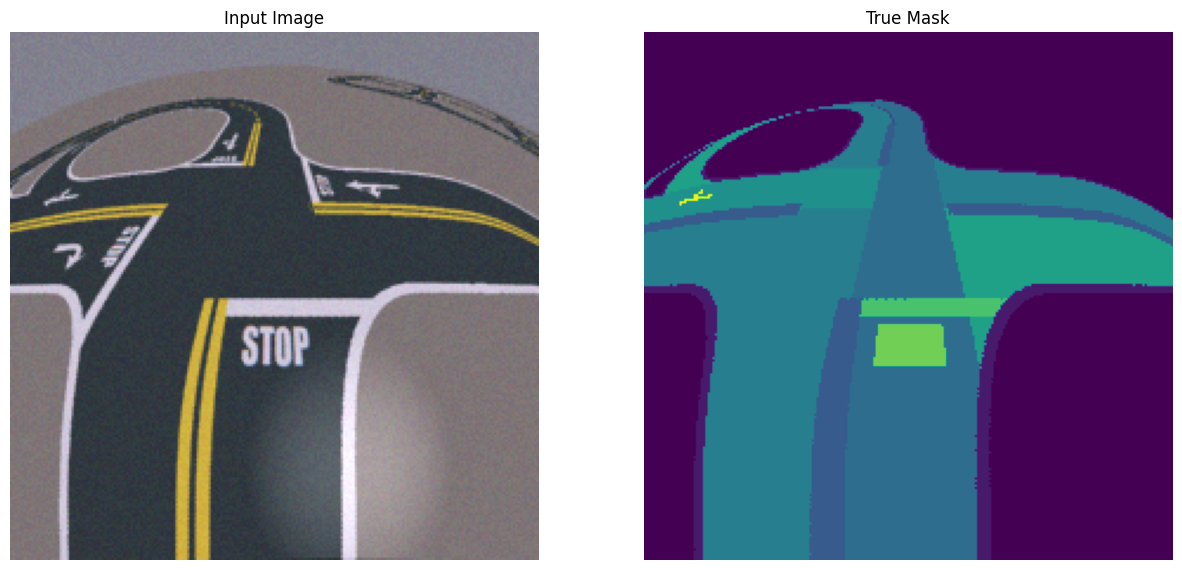

In [ ]:
# Get a set from training data
display_idx = random.randint(0,TRAINSET_SIZE-1)
print("Index:%d"%(display_idx))
img, mask = train_set[display_idx]

display([img,mask])

# Instantiate the UNet model

- Move the model to GPU


In [ ]:
import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained mobilenet backbone
#model = smp.Unet(encoder_name="mobilenet_v2", classes=N_CLASSES)
model = smp.UnetPlusPlus(encoder_name="timm-mobilenetv3_large_minimal_100", classes=N_CLASSES)

In [ ]:
# Uncomment below to show the model
#model

In [ ]:
# Uncomment below to show the model
#from torchsummary import summary
#summary(model.cpu(), input_size=(3, 224, 224))

In [ ]:
if os.path.exists(GDRIVE_PATH + MODEL_WEIGHT_FILE_NAME):
    model.load_state_dict(torch.load(GDRIVE_PATH + MODEL_WEIGHT_FILE_NAME))
    print('Last best model weights loaded!')

#Model training

We will optimize loss as the sum of IoU, Dice and BCE, specifically this function: IoU+Dice+0.8∗BCE.

In [ ]:
from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [ ]:
from torch import optim
from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = LEARNING_RATE
encoder_learning_rate = ENCODER_LEARNING_RATE

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=SCHEDULER_PATIENCE)

In [ ]:
from catalyst.dl import SupervisedRunner

# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [ ]:
if is_fp16_used:
    fp16_params = dict(opt_level=FP16_OPT_LEVEL) # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {LOG_DIR}

## Training

In [ ]:
from catalyst.dl import EarlyStoppingCallback

early_stop_callback = EarlyStoppingCallback(patience=EARLY_STOP_PATIENCE, metric="loss", minimize=True)

In [ ]:
from catalyst.dl import Callback, CallbackOrder, CallbackNode, IRunner

class SaveBestModelCallback(Callback):
    def __init__(
        self,
        metric: str = "loss",
        minimize: bool = True,
        min_delta: float = 1e-9,
        filename: str = "best_model.pth"
    ):
        super().__init__(order=CallbackOrder.external, node=CallbackNode.all)
        self.best_score = None
        self.metric = metric
        self.num_bad_epochs = 0
        self.is_better = None

        if minimize:
            self.is_better = lambda score, best: score <= (best - min_delta)
        else:
            self.is_better = lambda score, best: score >= (best + min_delta)

    def on_epoch_end(self, runner: "IRunner") -> None:
        if runner.stage.startswith("infer"):
            return

        score = runner.valid_metrics[self.metric]
        if self.best_score is None or self.is_better(score, self.best_score):
            print(f'Loss improved from {self.best_score} to {score}. ->Saving model weights!')
            torch.save(model.state_dict(), GDRIVE_PATH + MODEL_WEIGHT_FILE_NAME)
            self.num_bad_epochs = 0
            self.best_score = score
        else:
            self.num_bad_epochs += 1
            print(f'Loss did not improve from {self.best_score} for {self.num_bad_epochs} epoch(s)')


save_best_model_callback = SaveBestModelCallback(filename=GDRIVE_PATH + MODEL_WEIGHT_FILE_NAME)

In [ ]:
from catalyst.dl import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.5, "loss_iou": 1.0, "loss_bce": 0.2},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    IouCallback(input_key="mask"),

    early_stop_callback,
    save_best_model_callback
]

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=dataloaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=LOG_DIR,
    num_epochs=EPOCHS,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    # prints train logs
    verbose=False,
)

/usr/local/lib/python3.10/dist-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)



[2023-12-03 23:30:35,790] 
1/200 * Epoch 1 (_base): lr=5.000e-05 | momentum=0.9000
1/200 * Epoch 1 (train): dice=0.9804 | iou=0.9619 | loss=0.0686 | loss_bce=0.0059 | loss_dice=0.0196 | loss_iou=0.0381
1/200 * Epoch 1 (valid): dice=0.9803 | iou=0.9617 | loss=0.0689 | loss_bce=0.0055 | loss_dice=0.0197 | loss_iou=0.0383


INFO:metrics_logger:
1/200 * Epoch 1 (_base): lr=5.000e-05 | momentum=0.9000
1/200 * Epoch 1 (train): dice=0.9804 | iou=0.9619 | loss=0.0686 | loss_bce=0.0059 | loss_dice=0.0196 | loss_iou=0.0381
1/200 * Epoch 1 (valid): dice=0.9803 | iou=0.9617 | loss=0.0689 | loss_bce=0.0055 | loss_dice=0.0197 | loss_iou=0.0383


Loss improved from None to 0.06886080891612731. ->Saving model weights!
[2023-12-03 23:33:44,520] 
2/200 * Epoch 2 (_base): lr=5.000e-05 | momentum=0.9000
2/200 * Epoch 2 (train): dice=0.9829 | iou=0.9666 | loss=0.0601 | loss_bce=0.0050 | loss_dice=0.0171 | loss_iou=0.0334
2/200 * Epoch 2 (valid): dice=0.9821 | iou=0.9650 | loss=0.0628 | loss_bce=0.0048 | loss_dice=0.0179 | loss_iou=0.0350


INFO:metrics_logger:
2/200 * Epoch 2 (_base): lr=5.000e-05 | momentum=0.9000
2/200 * Epoch 2 (train): dice=0.9829 | iou=0.9666 | loss=0.0601 | loss_bce=0.0050 | loss_dice=0.0171 | loss_iou=0.0334
2/200 * Epoch 2 (valid): dice=0.9821 | iou=0.9650 | loss=0.0628 | loss_bce=0.0048 | loss_dice=0.0179 | loss_iou=0.0350


Loss improved from 0.06886080891612731 to 0.06283220438656427. ->Saving model weights!
[2023-12-03 23:36:53,618] 
3/200 * Epoch 3 (_base): lr=5.000e-05 | momentum=0.9000
3/200 * Epoch 3 (train): dice=0.9839 | iou=0.9686 | loss=0.0564 | loss_bce=0.0045 | loss_dice=0.0161 | loss_iou=0.0314
3/200 * Epoch 3 (valid): dice=0.9831 | iou=0.9669 | loss=0.0594 | loss_bce=0.0044 | loss_dice=0.0169 | loss_iou=0.0331


INFO:metrics_logger:
3/200 * Epoch 3 (_base): lr=5.000e-05 | momentum=0.9000
3/200 * Epoch 3 (train): dice=0.9839 | iou=0.9686 | loss=0.0564 | loss_bce=0.0045 | loss_dice=0.0161 | loss_iou=0.0314
3/200 * Epoch 3 (valid): dice=0.9831 | iou=0.9669 | loss=0.0594 | loss_bce=0.0044 | loss_dice=0.0169 | loss_iou=0.0331


Loss improved from 0.06283220438656427 to 0.059354117067603324. ->Saving model weights!
[2023-12-03 23:40:02,206] 
4/200 * Epoch 4 (_base): lr=5.000e-05 | momentum=0.9000
4/200 * Epoch 4 (train): dice=0.9847 | iou=0.9701 | loss=0.0538 | loss_bce=0.0042 | loss_dice=0.0153 | loss_iou=0.0299
4/200 * Epoch 4 (valid): dice=0.9838 | iou=0.9684 | loss=0.0568 | loss_bce=0.0040 | loss_dice=0.0162 | loss_iou=0.0316


INFO:metrics_logger:
4/200 * Epoch 4 (_base): lr=5.000e-05 | momentum=0.9000
4/200 * Epoch 4 (train): dice=0.9847 | iou=0.9701 | loss=0.0538 | loss_bce=0.0042 | loss_dice=0.0153 | loss_iou=0.0299
4/200 * Epoch 4 (valid): dice=0.9838 | iou=0.9684 | loss=0.0568 | loss_bce=0.0040 | loss_dice=0.0162 | loss_iou=0.0316


Loss improved from 0.059354117067603324 to 0.05677498806551348. ->Saving model weights!
[2023-12-03 23:43:11,222] 
5/200 * Epoch 5 (_base): lr=5.000e-05 | momentum=0.9000
5/200 * Epoch 5 (train): dice=0.9853 | iou=0.9713 | loss=0.0515 | loss_bce=0.0040 | loss_dice=0.0147 | loss_iou=0.0287
5/200 * Epoch 5 (valid): dice=0.9842 | iou=0.9692 | loss=0.0553 | loss_bce=0.0038 | loss_dice=0.0158 | loss_iou=0.0308


INFO:metrics_logger:
5/200 * Epoch 5 (_base): lr=5.000e-05 | momentum=0.9000
5/200 * Epoch 5 (train): dice=0.9853 | iou=0.9713 | loss=0.0515 | loss_bce=0.0040 | loss_dice=0.0147 | loss_iou=0.0287
5/200 * Epoch 5 (valid): dice=0.9842 | iou=0.9692 | loss=0.0553 | loss_bce=0.0038 | loss_dice=0.0158 | loss_iou=0.0308


Loss improved from 0.05677498806551348 to 0.055256004415880994. ->Saving model weights!
[2023-12-03 23:46:19,899] 
6/200 * Epoch 6 (_base): lr=5.000e-05 | momentum=0.9000
6/200 * Epoch 6 (train): dice=0.9857 | iou=0.9721 | loss=0.0501 | loss_bce=0.0038 | loss_dice=0.0143 | loss_iou=0.0279
6/200 * Epoch 6 (valid): dice=0.9849 | iou=0.9706 | loss=0.0527 | loss_bce=0.0036 | loss_dice=0.0151 | loss_iou=0.0294


INFO:metrics_logger:
6/200 * Epoch 6 (_base): lr=5.000e-05 | momentum=0.9000
6/200 * Epoch 6 (train): dice=0.9857 | iou=0.9721 | loss=0.0501 | loss_bce=0.0038 | loss_dice=0.0143 | loss_iou=0.0279
6/200 * Epoch 6 (valid): dice=0.9849 | iou=0.9706 | loss=0.0527 | loss_bce=0.0036 | loss_dice=0.0151 | loss_iou=0.0294


Loss improved from 0.055256004415880994 to 0.05269151487161366. ->Saving model weights!
[2023-12-03 23:49:28,996] 
7/200 * Epoch 7 (_base): lr=5.000e-05 | momentum=0.9000
7/200 * Epoch 7 (train): dice=0.9862 | iou=0.9730 | loss=0.0485 | loss_bce=0.0037 | loss_dice=0.0138 | loss_iou=0.0270
7/200 * Epoch 7 (valid): dice=0.9854 | iou=0.9715 | loss=0.0512 | loss_bce=0.0035 | loss_dice=0.0146 | loss_iou=0.0285


INFO:metrics_logger:
7/200 * Epoch 7 (_base): lr=5.000e-05 | momentum=0.9000
7/200 * Epoch 7 (train): dice=0.9862 | iou=0.9730 | loss=0.0485 | loss_bce=0.0037 | loss_dice=0.0138 | loss_iou=0.0270
7/200 * Epoch 7 (valid): dice=0.9854 | iou=0.9715 | loss=0.0512 | loss_bce=0.0035 | loss_dice=0.0146 | loss_iou=0.0285


Loss improved from 0.05269151487161366 to 0.051155755209955966. ->Saving model weights!
[2023-12-03 23:52:38,391] 
8/200 * Epoch 8 (_base): lr=5.000e-05 | momentum=0.9000
8/200 * Epoch 8 (train): dice=0.9862 | iou=0.9731 | loss=0.0483 | loss_bce=0.0036 | loss_dice=0.0138 | loss_iou=0.0269
8/200 * Epoch 8 (valid): dice=0.9859 | iou=0.9724 | loss=0.0495 | loss_bce=0.0034 | loss_dice=0.0141 | loss_iou=0.0276


INFO:metrics_logger:
8/200 * Epoch 8 (_base): lr=5.000e-05 | momentum=0.9000
8/200 * Epoch 8 (train): dice=0.9862 | iou=0.9731 | loss=0.0483 | loss_bce=0.0036 | loss_dice=0.0138 | loss_iou=0.0269
8/200 * Epoch 8 (valid): dice=0.9859 | iou=0.9724 | loss=0.0495 | loss_bce=0.0034 | loss_dice=0.0141 | loss_iou=0.0276


Loss improved from 0.051155755209955966 to 0.04951674264470368. ->Saving model weights!
[2023-12-03 23:55:47,833] 
9/200 * Epoch 9 (_base): lr=5.000e-05 | momentum=0.9000
9/200 * Epoch 9 (train): dice=0.9865 | iou=0.9736 | loss=0.0473 | loss_bce=0.0035 | loss_dice=0.0135 | loss_iou=0.0264
9/200 * Epoch 9 (valid): dice=0.9857 | iou=0.9722 | loss=0.0499 | loss_bce=0.0033 | loss_dice=0.0143 | loss_iou=0.0278


INFO:metrics_logger:
9/200 * Epoch 9 (_base): lr=5.000e-05 | momentum=0.9000
9/200 * Epoch 9 (train): dice=0.9865 | iou=0.9736 | loss=0.0473 | loss_bce=0.0035 | loss_dice=0.0135 | loss_iou=0.0264
9/200 * Epoch 9 (valid): dice=0.9857 | iou=0.9722 | loss=0.0499 | loss_bce=0.0033 | loss_dice=0.0143 | loss_iou=0.0278


Loss did not improve from 0.04951674264470368 for 1 epoch(s)
[2023-12-03 23:58:56,830] 
10/200 * Epoch 10 (_base): lr=5.000e-05 | momentum=0.9000
10/200 * Epoch 10 (train): dice=0.9869 | iou=0.9743 | loss=0.0461 | loss_bce=0.0035 | loss_dice=0.0131 | loss_iou=0.0257
10/200 * Epoch 10 (valid): dice=0.9859 | iou=0.9726 | loss=0.0491 | loss_bce=0.0033 | loss_dice=0.0141 | loss_iou=0.0274


INFO:metrics_logger:
10/200 * Epoch 10 (_base): lr=5.000e-05 | momentum=0.9000
10/200 * Epoch 10 (train): dice=0.9869 | iou=0.9743 | loss=0.0461 | loss_bce=0.0035 | loss_dice=0.0131 | loss_iou=0.0257
10/200 * Epoch 10 (valid): dice=0.9859 | iou=0.9726 | loss=0.0491 | loss_bce=0.0033 | loss_dice=0.0141 | loss_iou=0.0274


Loss improved from 0.04951674264470368 to 0.049126378569841825. ->Saving model weights!
[2023-12-04 00:02:06,410] 
11/200 * Epoch 11 (_base): lr=5.000e-05 | momentum=0.9000
11/200 * Epoch 11 (train): dice=0.9870 | iou=0.9746 | loss=0.0456 | loss_bce=0.0034 | loss_dice=0.0130 | loss_iou=0.0254
11/200 * Epoch 11 (valid): dice=0.9862 | iou=0.9730 | loss=0.0484 | loss_bce=0.0032 | loss_dice=0.0138 | loss_iou=0.0270


INFO:metrics_logger:
11/200 * Epoch 11 (_base): lr=5.000e-05 | momentum=0.9000
11/200 * Epoch 11 (train): dice=0.9870 | iou=0.9746 | loss=0.0456 | loss_bce=0.0034 | loss_dice=0.0130 | loss_iou=0.0254
11/200 * Epoch 11 (valid): dice=0.9862 | iou=0.9730 | loss=0.0484 | loss_bce=0.0032 | loss_dice=0.0138 | loss_iou=0.0270


Loss improved from 0.049126378569841825 to 0.04843129893567876. ->Saving model weights!
[2023-12-04 00:05:15,726] 
12/200 * Epoch 12 (_base): lr=1.250e-05 | momentum=0.9000
12/200 * Epoch 12 (train): dice=0.9872 | iou=0.9749 | loss=0.0450 | loss_bce=0.0034 | loss_dice=0.0128 | loss_iou=0.0251
12/200 * Epoch 12 (valid): dice=0.9864 | iou=0.9734 | loss=0.0477 | loss_bce=0.0032 | loss_dice=0.0136 | loss_iou=0.0266


INFO:metrics_logger:
12/200 * Epoch 12 (_base): lr=1.250e-05 | momentum=0.9000
12/200 * Epoch 12 (train): dice=0.9872 | iou=0.9749 | loss=0.0450 | loss_bce=0.0034 | loss_dice=0.0128 | loss_iou=0.0251
12/200 * Epoch 12 (valid): dice=0.9864 | iou=0.9734 | loss=0.0477 | loss_bce=0.0032 | loss_dice=0.0136 | loss_iou=0.0266


Loss improved from 0.04843129893567876 to 0.047721434985883604. ->Saving model weights!
[2023-12-04 00:08:24,047] 
13/200 * Epoch 13 (_base): lr=1.250e-05 | momentum=0.9000
13/200 * Epoch 13 (train): dice=0.9872 | iou=0.9750 | loss=0.0449 | loss_bce=0.0034 | loss_dice=0.0128 | loss_iou=0.0250
13/200 * Epoch 13 (valid): dice=0.9865 | iou=0.9737 | loss=0.0472 | loss_bce=0.0032 | loss_dice=0.0135 | loss_iou=0.0263


INFO:metrics_logger:
13/200 * Epoch 13 (_base): lr=1.250e-05 | momentum=0.9000
13/200 * Epoch 13 (train): dice=0.9872 | iou=0.9750 | loss=0.0449 | loss_bce=0.0034 | loss_dice=0.0128 | loss_iou=0.0250
13/200 * Epoch 13 (valid): dice=0.9865 | iou=0.9737 | loss=0.0472 | loss_bce=0.0032 | loss_dice=0.0135 | loss_iou=0.0263


Loss improved from 0.047721434985883604 to 0.04715051211707004. ->Saving model weights!
[2023-12-04 00:11:32,256] 
14/200 * Epoch 14 (_base): lr=1.250e-05 | momentum=0.9000
14/200 * Epoch 14 (train): dice=0.9873 | iou=0.9751 | loss=0.0446 | loss_bce=0.0034 | loss_dice=0.0127 | loss_iou=0.0249
14/200 * Epoch 14 (valid): dice=0.9865 | iou=0.9737 | loss=0.0471 | loss_bce=0.0032 | loss_dice=0.0135 | loss_iou=0.0263


INFO:metrics_logger:
14/200 * Epoch 14 (_base): lr=1.250e-05 | momentum=0.9000
14/200 * Epoch 14 (train): dice=0.9873 | iou=0.9751 | loss=0.0446 | loss_bce=0.0034 | loss_dice=0.0127 | loss_iou=0.0249
14/200 * Epoch 14 (valid): dice=0.9865 | iou=0.9737 | loss=0.0471 | loss_bce=0.0032 | loss_dice=0.0135 | loss_iou=0.0263


Loss improved from 0.04715051211707004 to 0.04714320455582774. ->Saving model weights!
[2023-12-04 00:14:40,806] 
15/200 * Epoch 15 (_base): lr=1.250e-05 | momentum=0.9000
15/200 * Epoch 15 (train): dice=0.9874 | iou=0.9753 | loss=0.0442 | loss_bce=0.0033 | loss_dice=0.0126 | loss_iou=0.0247
15/200 * Epoch 15 (valid): dice=0.9866 | iou=0.9738 | loss=0.0469 | loss_bce=0.0031 | loss_dice=0.0134 | loss_iou=0.0262


INFO:metrics_logger:
15/200 * Epoch 15 (_base): lr=1.250e-05 | momentum=0.9000
15/200 * Epoch 15 (train): dice=0.9874 | iou=0.9753 | loss=0.0442 | loss_bce=0.0033 | loss_dice=0.0126 | loss_iou=0.0247
15/200 * Epoch 15 (valid): dice=0.9866 | iou=0.9738 | loss=0.0469 | loss_bce=0.0031 | loss_dice=0.0134 | loss_iou=0.0262


Loss improved from 0.04714320455582774 to 0.04685091275673407. ->Saving model weights!
[2023-12-04 00:17:49,992] 
16/200 * Epoch 16 (_base): lr=1.250e-05 | momentum=0.9000
16/200 * Epoch 16 (train): dice=0.9874 | iou=0.9754 | loss=0.0442 | loss_bce=0.0033 | loss_dice=0.0126 | loss_iou=0.0246
16/200 * Epoch 16 (valid): dice=0.9864 | iou=0.9734 | loss=0.0476 | loss_bce=0.0031 | loss_dice=0.0136 | loss_iou=0.0266


INFO:metrics_logger:
16/200 * Epoch 16 (_base): lr=1.250e-05 | momentum=0.9000
16/200 * Epoch 16 (train): dice=0.9874 | iou=0.9754 | loss=0.0442 | loss_bce=0.0033 | loss_dice=0.0126 | loss_iou=0.0246
16/200 * Epoch 16 (valid): dice=0.9864 | iou=0.9734 | loss=0.0476 | loss_bce=0.0031 | loss_dice=0.0136 | loss_iou=0.0266


Loss did not improve from 0.04685091275673407 for 1 epoch(s)
[2023-12-04 00:20:58,424] 
17/200 * Epoch 17 (_base): lr=1.250e-05 | momentum=0.9000
17/200 * Epoch 17 (train): dice=0.9873 | iou=0.9752 | loss=0.0445 | loss_bce=0.0033 | loss_dice=0.0127 | loss_iou=0.0248
17/200 * Epoch 17 (valid): dice=0.9867 | iou=0.9740 | loss=0.0465 | loss_bce=0.0031 | loss_dice=0.0133 | loss_iou=0.0260


INFO:metrics_logger:
17/200 * Epoch 17 (_base): lr=1.250e-05 | momentum=0.9000
17/200 * Epoch 17 (train): dice=0.9873 | iou=0.9752 | loss=0.0445 | loss_bce=0.0033 | loss_dice=0.0127 | loss_iou=0.0248
17/200 * Epoch 17 (valid): dice=0.9867 | iou=0.9740 | loss=0.0465 | loss_bce=0.0031 | loss_dice=0.0133 | loss_iou=0.0260


Loss improved from 0.04685091275673407 to 0.04654769379652497. ->Saving model weights!
[2023-12-04 00:24:07,441] 
18/200 * Epoch 18 (_base): lr=1.250e-05 | momentum=0.9000
18/200 * Epoch 18 (train): dice=0.9874 | iou=0.9754 | loss=0.0442 | loss_bce=0.0033 | loss_dice=0.0126 | loss_iou=0.0246
18/200 * Epoch 18 (valid): dice=0.9864 | iou=0.9734 | loss=0.0477 | loss_bce=0.0031 | loss_dice=0.0136 | loss_iou=0.0266


INFO:metrics_logger:
18/200 * Epoch 18 (_base): lr=1.250e-05 | momentum=0.9000
18/200 * Epoch 18 (train): dice=0.9874 | iou=0.9754 | loss=0.0442 | loss_bce=0.0033 | loss_dice=0.0126 | loss_iou=0.0246
18/200 * Epoch 18 (valid): dice=0.9864 | iou=0.9734 | loss=0.0477 | loss_bce=0.0031 | loss_dice=0.0136 | loss_iou=0.0266


Loss did not improve from 0.04654769379652497 for 1 epoch(s)
[2023-12-04 00:27:16,072] 
19/200 * Epoch 19 (_base): lr=1.250e-05 | momentum=0.9000
19/200 * Epoch 19 (train): dice=0.9875 | iou=0.9755 | loss=0.0440 | loss_bce=0.0033 | loss_dice=0.0125 | loss_iou=0.0245
19/200 * Epoch 19 (valid): dice=0.9867 | iou=0.9741 | loss=0.0464 | loss_bce=0.0031 | loss_dice=0.0133 | loss_iou=0.0259


INFO:metrics_logger:
19/200 * Epoch 19 (_base): lr=1.250e-05 | momentum=0.9000
19/200 * Epoch 19 (train): dice=0.9875 | iou=0.9755 | loss=0.0440 | loss_bce=0.0033 | loss_dice=0.0125 | loss_iou=0.0245
19/200 * Epoch 19 (valid): dice=0.9867 | iou=0.9741 | loss=0.0464 | loss_bce=0.0031 | loss_dice=0.0133 | loss_iou=0.0259


Loss improved from 0.04654769379652497 to 0.04642608820535035. ->Saving model weights!
[2023-12-04 00:30:25,027] 
20/200 * Epoch 20 (_base): lr=1.250e-05 | momentum=0.9000
20/200 * Epoch 20 (train): dice=0.9876 | iou=0.9757 | loss=0.0435 | loss_bce=0.0033 | loss_dice=0.0124 | loss_iou=0.0243
20/200 * Epoch 20 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0031 | loss_dice=0.0132 | loss_iou=0.0258


INFO:metrics_logger:
20/200 * Epoch 20 (_base): lr=1.250e-05 | momentum=0.9000
20/200 * Epoch 20 (train): dice=0.9876 | iou=0.9757 | loss=0.0435 | loss_bce=0.0033 | loss_dice=0.0124 | loss_iou=0.0243
20/200 * Epoch 20 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0031 | loss_dice=0.0132 | loss_iou=0.0258


Loss improved from 0.04642608820535035 to 0.04622563087348593. ->Saving model weights!
[2023-12-04 00:33:34,535] 
21/200 * Epoch 21 (_base): lr=1.250e-05 | momentum=0.9000
21/200 * Epoch 21 (train): dice=0.9875 | iou=0.9756 | loss=0.0437 | loss_bce=0.0033 | loss_dice=0.0125 | loss_iou=0.0244
21/200 * Epoch 21 (valid): dice=0.9867 | iou=0.9740 | loss=0.0466 | loss_bce=0.0031 | loss_dice=0.0133 | loss_iou=0.0260


INFO:metrics_logger:
21/200 * Epoch 21 (_base): lr=1.250e-05 | momentum=0.9000
21/200 * Epoch 21 (train): dice=0.9875 | iou=0.9756 | loss=0.0437 | loss_bce=0.0033 | loss_dice=0.0125 | loss_iou=0.0244
21/200 * Epoch 21 (valid): dice=0.9867 | iou=0.9740 | loss=0.0466 | loss_bce=0.0031 | loss_dice=0.0133 | loss_iou=0.0260


Loss did not improve from 0.04622563087348593 for 1 epoch(s)
[2023-12-04 00:36:43,596] 
22/200 * Epoch 22 (_base): lr=1.250e-05 | momentum=0.9000
22/200 * Epoch 22 (train): dice=0.9876 | iou=0.9758 | loss=0.0434 | loss_bce=0.0033 | loss_dice=0.0124 | loss_iou=0.0242
22/200 * Epoch 22 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0031 | loss_dice=0.0132 | loss_iou=0.0258


INFO:metrics_logger:
22/200 * Epoch 22 (_base): lr=1.250e-05 | momentum=0.9000
22/200 * Epoch 22 (train): dice=0.9876 | iou=0.9758 | loss=0.0434 | loss_bce=0.0033 | loss_dice=0.0124 | loss_iou=0.0242
22/200 * Epoch 22 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0031 | loss_dice=0.0132 | loss_iou=0.0258


Loss improved from 0.04622563087348593 to 0.046179674365359025. ->Saving model weights!
[2023-12-04 00:39:52,623] 
23/200 * Epoch 23 (_base): lr=3.125e-06 | momentum=0.9000
23/200 * Epoch 23 (train): dice=0.9877 | iou=0.9759 | loss=0.0432 | loss_bce=0.0033 | loss_dice=0.0123 | loss_iou=0.0241
23/200 * Epoch 23 (valid): dice=0.9869 | iou=0.9745 | loss=0.0458 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


INFO:metrics_logger:
23/200 * Epoch 23 (_base): lr=3.125e-06 | momentum=0.9000
23/200 * Epoch 23 (train): dice=0.9877 | iou=0.9759 | loss=0.0432 | loss_bce=0.0033 | loss_dice=0.0123 | loss_iou=0.0241
23/200 * Epoch 23 (valid): dice=0.9869 | iou=0.9745 | loss=0.0458 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


Loss improved from 0.046179674365359025 to 0.045750649594088436. ->Saving model weights!
[2023-12-04 00:43:01,355] 
24/200 * Epoch 24 (_base): lr=3.125e-06 | momentum=0.9000
24/200 * Epoch 24 (train): dice=0.9877 | iou=0.9759 | loss=0.0431 | loss_bce=0.0033 | loss_dice=0.0123 | loss_iou=0.0241
24/200 * Epoch 24 (valid): dice=0.9869 | iou=0.9744 | loss=0.0459 | loss_bce=0.0031 | loss_dice=0.0131 | loss_iou=0.0256


INFO:metrics_logger:
24/200 * Epoch 24 (_base): lr=3.125e-06 | momentum=0.9000
24/200 * Epoch 24 (train): dice=0.9877 | iou=0.9759 | loss=0.0431 | loss_bce=0.0033 | loss_dice=0.0123 | loss_iou=0.0241
24/200 * Epoch 24 (valid): dice=0.9869 | iou=0.9744 | loss=0.0459 | loss_bce=0.0031 | loss_dice=0.0131 | loss_iou=0.0256


Loss did not improve from 0.045750649594088436 for 1 epoch(s)
[2023-12-04 00:46:12,233] 
25/200 * Epoch 25 (_base): lr=3.125e-06 | momentum=0.9000
25/200 * Epoch 25 (train): dice=0.9876 | iou=0.9757 | loss=0.0435 | loss_bce=0.0033 | loss_dice=0.0124 | loss_iou=0.0243
25/200 * Epoch 25 (valid): dice=0.9868 | iou=0.9743 | loss=0.0461 | loss_bce=0.0031 | loss_dice=0.0132 | loss_iou=0.0257


INFO:metrics_logger:
25/200 * Epoch 25 (_base): lr=3.125e-06 | momentum=0.9000
25/200 * Epoch 25 (train): dice=0.9876 | iou=0.9757 | loss=0.0435 | loss_bce=0.0033 | loss_dice=0.0124 | loss_iou=0.0243
25/200 * Epoch 25 (valid): dice=0.9868 | iou=0.9743 | loss=0.0461 | loss_bce=0.0031 | loss_dice=0.0132 | loss_iou=0.0257


Loss did not improve from 0.045750649594088436 for 2 epoch(s)
[2023-12-04 00:49:24,684] 
26/200 * Epoch 26 (_base): lr=3.125e-06 | momentum=0.9000
26/200 * Epoch 26 (train): dice=0.9876 | iou=0.9757 | loss=0.0435 | loss_bce=0.0032 | loss_dice=0.0124 | loss_iou=0.0243
26/200 * Epoch 26 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


INFO:metrics_logger:
26/200 * Epoch 26 (_base): lr=3.125e-06 | momentum=0.9000
26/200 * Epoch 26 (train): dice=0.9876 | iou=0.9757 | loss=0.0435 | loss_bce=0.0032 | loss_dice=0.0124 | loss_iou=0.0243
26/200 * Epoch 26 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


Loss did not improve from 0.045750649594088436 for 3 epoch(s)
[2023-12-04 00:52:36,612] 
27/200 * Epoch 27 (_base): lr=3.125e-06 | momentum=0.9000
27/200 * Epoch 27 (train): dice=0.9877 | iou=0.9760 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
27/200 * Epoch 27 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


INFO:metrics_logger:
27/200 * Epoch 27 (_base): lr=3.125e-06 | momentum=0.9000
27/200 * Epoch 27 (train): dice=0.9877 | iou=0.9760 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
27/200 * Epoch 27 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


Loss did not improve from 0.045750649594088436 for 4 epoch(s)
[2023-12-04 00:55:48,259] 
28/200 * Epoch 28 (_base): lr=3.125e-06 | momentum=0.9000
28/200 * Epoch 28 (train): dice=0.9876 | iou=0.9758 | loss=0.0433 | loss_bce=0.0032 | loss_dice=0.0124 | loss_iou=0.0242
28/200 * Epoch 28 (valid): dice=0.9868 | iou=0.9743 | loss=0.0461 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0257


INFO:metrics_logger:
28/200 * Epoch 28 (_base): lr=3.125e-06 | momentum=0.9000
28/200 * Epoch 28 (train): dice=0.9876 | iou=0.9758 | loss=0.0433 | loss_bce=0.0032 | loss_dice=0.0124 | loss_iou=0.0242
28/200 * Epoch 28 (valid): dice=0.9868 | iou=0.9743 | loss=0.0461 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0257


Loss did not improve from 0.045750649594088436 for 5 epoch(s)
[2023-12-04 00:58:57,150] 
29/200 * Epoch 29 (_base): lr=3.125e-06 | momentum=0.9000
29/200 * Epoch 29 (train): dice=0.9877 | iou=0.9759 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0241
29/200 * Epoch 29 (valid): dice=0.9868 | iou=0.9742 | loss=0.0463 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


INFO:metrics_logger:
29/200 * Epoch 29 (_base): lr=3.125e-06 | momentum=0.9000
29/200 * Epoch 29 (train): dice=0.9877 | iou=0.9759 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0241
29/200 * Epoch 29 (valid): dice=0.9868 | iou=0.9742 | loss=0.0463 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


Loss did not improve from 0.045750649594088436 for 6 epoch(s)
[2023-12-04 01:02:05,155] 
30/200 * Epoch 30 (_base): lr=3.125e-06 | momentum=0.9000
30/200 * Epoch 30 (train): dice=0.9878 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0240
30/200 * Epoch 30 (valid): dice=0.9869 | iou=0.9745 | loss=0.0458 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


INFO:metrics_logger:
30/200 * Epoch 30 (_base): lr=3.125e-06 | momentum=0.9000
30/200 * Epoch 30 (train): dice=0.9878 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0240
30/200 * Epoch 30 (valid): dice=0.9869 | iou=0.9745 | loss=0.0458 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


Loss did not improve from 0.045750649594088436 for 7 epoch(s)
[2023-12-04 01:05:13,743] 
31/200 * Epoch 31 (_base): lr=3.125e-06 | momentum=0.9000
31/200 * Epoch 31 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
31/200 * Epoch 31 (valid): dice=0.9871 | iou=0.9748 | loss=0.0452 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


INFO:metrics_logger:
31/200 * Epoch 31 (_base): lr=3.125e-06 | momentum=0.9000
31/200 * Epoch 31 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
31/200 * Epoch 31 (valid): dice=0.9871 | iou=0.9748 | loss=0.0452 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


Loss improved from 0.045750649594088436 to 0.04518812064060696. ->Saving model weights!
[2023-12-04 01:08:22,640] 
32/200 * Epoch 32 (_base): lr=3.125e-06 | momentum=0.9000
32/200 * Epoch 32 (train): dice=0.9876 | iou=0.9758 | loss=0.0434 | loss_bce=0.0032 | loss_dice=0.0124 | loss_iou=0.0242
32/200 * Epoch 32 (valid): dice=0.9867 | iou=0.9741 | loss=0.0465 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0259


INFO:metrics_logger:
32/200 * Epoch 32 (_base): lr=3.125e-06 | momentum=0.9000
32/200 * Epoch 32 (train): dice=0.9876 | iou=0.9758 | loss=0.0434 | loss_bce=0.0032 | loss_dice=0.0124 | loss_iou=0.0242
32/200 * Epoch 32 (valid): dice=0.9867 | iou=0.9741 | loss=0.0465 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0259


Loss did not improve from 0.04518812064060696 for 1 epoch(s)
[2023-12-04 01:11:30,890] 
33/200 * Epoch 33 (_base): lr=3.125e-06 | momentum=0.9000
33/200 * Epoch 33 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
33/200 * Epoch 33 (valid): dice=0.9869 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


INFO:metrics_logger:
33/200 * Epoch 33 (_base): lr=3.125e-06 | momentum=0.9000
33/200 * Epoch 33 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
33/200 * Epoch 33 (valid): dice=0.9869 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


Loss did not improve from 0.04518812064060696 for 2 epoch(s)
[2023-12-04 01:14:39,952] 
34/200 * Epoch 34 (_base): lr=7.813e-07 | momentum=0.9000
34/200 * Epoch 34 (train): dice=0.9877 | iou=0.9759 | loss=0.0432 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0241
34/200 * Epoch 34 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


INFO:metrics_logger:
34/200 * Epoch 34 (_base): lr=7.813e-07 | momentum=0.9000
34/200 * Epoch 34 (train): dice=0.9877 | iou=0.9759 | loss=0.0432 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0241
34/200 * Epoch 34 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


Loss did not improve from 0.04518812064060696 for 3 epoch(s)
[2023-12-04 01:17:48,891] 
35/200 * Epoch 35 (_base): lr=7.813e-07 | momentum=0.9000
35/200 * Epoch 35 (train): dice=0.9877 | iou=0.9760 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
35/200 * Epoch 35 (valid): dice=0.9871 | iou=0.9748 | loss=0.0452 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


INFO:metrics_logger:
35/200 * Epoch 35 (_base): lr=7.813e-07 | momentum=0.9000
35/200 * Epoch 35 (train): dice=0.9877 | iou=0.9760 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
35/200 * Epoch 35 (valid): dice=0.9871 | iou=0.9748 | loss=0.0452 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


Loss improved from 0.04518812064060696 to 0.0451861878300642. ->Saving model weights!
[2023-12-04 01:20:57,178] 
36/200 * Epoch 36 (_base): lr=7.813e-07 | momentum=0.9000
36/200 * Epoch 36 (train): dice=0.9877 | iou=0.9760 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
36/200 * Epoch 36 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


INFO:metrics_logger:
36/200 * Epoch 36 (_base): lr=7.813e-07 | momentum=0.9000
36/200 * Epoch 36 (train): dice=0.9877 | iou=0.9760 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
36/200 * Epoch 36 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


Loss did not improve from 0.0451861878300642 for 1 epoch(s)
[2023-12-04 01:24:04,476] 
37/200 * Epoch 37 (_base): lr=7.813e-07 | momentum=0.9000
37/200 * Epoch 37 (train): dice=0.9878 | iou=0.9762 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
37/200 * Epoch 37 (valid): dice=0.9868 | iou=0.9743 | loss=0.0461 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0257


INFO:metrics_logger:
37/200 * Epoch 37 (_base): lr=7.813e-07 | momentum=0.9000
37/200 * Epoch 37 (train): dice=0.9878 | iou=0.9762 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
37/200 * Epoch 37 (valid): dice=0.9868 | iou=0.9743 | loss=0.0461 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0257


Loss did not improve from 0.0451861878300642 for 2 epoch(s)
[2023-12-04 01:27:12,526] 
38/200 * Epoch 38 (_base): lr=7.813e-07 | momentum=0.9000
38/200 * Epoch 38 (train): dice=0.9877 | iou=0.9759 | loss=0.0432 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0241
38/200 * Epoch 38 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


INFO:metrics_logger:
38/200 * Epoch 38 (_base): lr=7.813e-07 | momentum=0.9000
38/200 * Epoch 38 (train): dice=0.9877 | iou=0.9759 | loss=0.0432 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0241
38/200 * Epoch 38 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


Loss did not improve from 0.0451861878300642 for 3 epoch(s)
[2023-12-04 01:30:19,901] 
39/200 * Epoch 39 (_base): lr=7.813e-07 | momentum=0.9000
39/200 * Epoch 39 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
39/200 * Epoch 39 (valid): dice=0.9870 | iou=0.9746 | loss=0.0455 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


INFO:metrics_logger:
39/200 * Epoch 39 (_base): lr=7.813e-07 | momentum=0.9000
39/200 * Epoch 39 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
39/200 * Epoch 39 (valid): dice=0.9870 | iou=0.9746 | loss=0.0455 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


Loss did not improve from 0.0451861878300642 for 4 epoch(s)
[2023-12-04 01:33:27,331] 
40/200 * Epoch 40 (_base): lr=7.813e-07 | momentum=0.9000
40/200 * Epoch 40 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
40/200 * Epoch 40 (valid): dice=0.9867 | iou=0.9741 | loss=0.0464 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0259


INFO:metrics_logger:
40/200 * Epoch 40 (_base): lr=7.813e-07 | momentum=0.9000
40/200 * Epoch 40 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
40/200 * Epoch 40 (valid): dice=0.9867 | iou=0.9741 | loss=0.0464 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0259


Loss did not improve from 0.0451861878300642 for 5 epoch(s)
[2023-12-04 01:36:34,974] 
41/200 * Epoch 41 (_base): lr=7.813e-07 | momentum=0.9000
41/200 * Epoch 41 (train): dice=0.9878 | iou=0.9762 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
41/200 * Epoch 41 (valid): dice=0.9870 | iou=0.9745 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0255


INFO:metrics_logger:
41/200 * Epoch 41 (_base): lr=7.813e-07 | momentum=0.9000
41/200 * Epoch 41 (train): dice=0.9878 | iou=0.9762 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
41/200 * Epoch 41 (valid): dice=0.9870 | iou=0.9745 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0255


Loss did not improve from 0.0451861878300642 for 6 epoch(s)
[2023-12-04 01:39:44,361] 
42/200 * Epoch 42 (_base): lr=7.813e-07 | momentum=0.9000
42/200 * Epoch 42 (train): dice=0.9877 | iou=0.9760 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
42/200 * Epoch 42 (valid): dice=0.9869 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


INFO:metrics_logger:
42/200 * Epoch 42 (_base): lr=7.813e-07 | momentum=0.9000
42/200 * Epoch 42 (train): dice=0.9877 | iou=0.9760 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
42/200 * Epoch 42 (valid): dice=0.9869 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


Loss did not improve from 0.0451861878300642 for 7 epoch(s)
[2023-12-04 01:42:54,181] 
43/200 * Epoch 43 (_base): lr=7.813e-07 | momentum=0.9000
43/200 * Epoch 43 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
43/200 * Epoch 43 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


INFO:metrics_logger:
43/200 * Epoch 43 (_base): lr=7.813e-07 | momentum=0.9000
43/200 * Epoch 43 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
43/200 * Epoch 43 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


Loss did not improve from 0.0451861878300642 for 8 epoch(s)
[2023-12-04 01:46:02,814] 
44/200 * Epoch 44 (_base): lr=7.813e-07 | momentum=0.9000
44/200 * Epoch 44 (train): dice=0.9878 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0240
44/200 * Epoch 44 (valid): dice=0.9868 | iou=0.9742 | loss=0.0463 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


INFO:metrics_logger:
44/200 * Epoch 44 (_base): lr=7.813e-07 | momentum=0.9000
44/200 * Epoch 44 (train): dice=0.9878 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0240
44/200 * Epoch 44 (valid): dice=0.9868 | iou=0.9742 | loss=0.0463 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


Loss did not improve from 0.0451861878300642 for 9 epoch(s)
[2023-12-04 01:49:12,890] 
45/200 * Epoch 45 (_base): lr=1.953e-07 | momentum=0.9000
45/200 * Epoch 45 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
45/200 * Epoch 45 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


INFO:metrics_logger:
45/200 * Epoch 45 (_base): lr=1.953e-07 | momentum=0.9000
45/200 * Epoch 45 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
45/200 * Epoch 45 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


Loss did not improve from 0.0451861878300642 for 10 epoch(s)
[2023-12-04 01:52:21,430] 
46/200 * Epoch 46 (_base): lr=1.953e-07 | momentum=0.9000
46/200 * Epoch 46 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
46/200 * Epoch 46 (valid): dice=0.9869 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


INFO:metrics_logger:
46/200 * Epoch 46 (_base): lr=1.953e-07 | momentum=0.9000
46/200 * Epoch 46 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
46/200 * Epoch 46 (valid): dice=0.9869 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


Loss did not improve from 0.0451861878300642 for 11 epoch(s)
[2023-12-04 01:55:29,177] 
47/200 * Epoch 47 (_base): lr=1.953e-07 | momentum=0.9000
47/200 * Epoch 47 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
47/200 * Epoch 47 (valid): dice=0.9870 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0253


INFO:metrics_logger:
47/200 * Epoch 47 (_base): lr=1.953e-07 | momentum=0.9000
47/200 * Epoch 47 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
47/200 * Epoch 47 (valid): dice=0.9870 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0253


Loss did not improve from 0.0451861878300642 for 12 epoch(s)
[2023-12-04 01:58:36,857] 
48/200 * Epoch 48 (_base): lr=1.953e-07 | momentum=0.9000
48/200 * Epoch 48 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
48/200 * Epoch 48 (valid): dice=0.9870 | iou=0.9745 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0255


INFO:metrics_logger:
48/200 * Epoch 48 (_base): lr=1.953e-07 | momentum=0.9000
48/200 * Epoch 48 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
48/200 * Epoch 48 (valid): dice=0.9870 | iou=0.9745 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0255


Loss did not improve from 0.0451861878300642 for 13 epoch(s)
[2023-12-04 02:01:43,871] 
49/200 * Epoch 49 (_base): lr=1.953e-07 | momentum=0.9000
49/200 * Epoch 49 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
49/200 * Epoch 49 (valid): dice=0.9870 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0253


INFO:metrics_logger:
49/200 * Epoch 49 (_base): lr=1.953e-07 | momentum=0.9000
49/200 * Epoch 49 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
49/200 * Epoch 49 (valid): dice=0.9870 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0253


Loss did not improve from 0.0451861878300642 for 14 epoch(s)
[2023-12-04 02:04:50,814] 
50/200 * Epoch 50 (_base): lr=1.953e-07 | momentum=0.9000
50/200 * Epoch 50 (train): dice=0.9877 | iou=0.9759 | loss=0.0432 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0241
50/200 * Epoch 50 (valid): dice=0.9871 | iou=0.9748 | loss=0.0452 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


INFO:metrics_logger:
50/200 * Epoch 50 (_base): lr=1.953e-07 | momentum=0.9000
50/200 * Epoch 50 (train): dice=0.9877 | iou=0.9759 | loss=0.0432 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0241
50/200 * Epoch 50 (valid): dice=0.9871 | iou=0.9748 | loss=0.0452 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


Loss did not improve from 0.0451861878300642 for 15 epoch(s)
[2023-12-04 02:07:57,703] 
51/200 * Epoch 51 (_base): lr=1.953e-07 | momentum=0.9000
51/200 * Epoch 51 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
51/200 * Epoch 51 (valid): dice=0.9872 | iou=0.9750 | loss=0.0448 | loss_bce=0.0030 | loss_dice=0.0128 | loss_iou=0.0250


INFO:metrics_logger:
51/200 * Epoch 51 (_base): lr=1.953e-07 | momentum=0.9000
51/200 * Epoch 51 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
51/200 * Epoch 51 (valid): dice=0.9872 | iou=0.9750 | loss=0.0448 | loss_bce=0.0030 | loss_dice=0.0128 | loss_iou=0.0250


Loss improved from 0.0451861878300642 to 0.04478964748652392. ->Saving model weights!
[2023-12-04 02:11:05,836] 
52/200 * Epoch 52 (_base): lr=1.953e-07 | momentum=0.9000
52/200 * Epoch 52 (train): dice=0.9877 | iou=0.9760 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
52/200 * Epoch 52 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


INFO:metrics_logger:
52/200 * Epoch 52 (_base): lr=1.953e-07 | momentum=0.9000
52/200 * Epoch 52 (train): dice=0.9877 | iou=0.9760 | loss=0.0431 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
52/200 * Epoch 52 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


Loss did not improve from 0.04478964748652392 for 1 epoch(s)
[2023-12-04 02:14:13,058] 
53/200 * Epoch 53 (_base): lr=1.953e-07 | momentum=0.9000
53/200 * Epoch 53 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
53/200 * Epoch 53 (valid): dice=0.9869 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


INFO:metrics_logger:
53/200 * Epoch 53 (_base): lr=1.953e-07 | momentum=0.9000
53/200 * Epoch 53 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
53/200 * Epoch 53 (valid): dice=0.9869 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


Loss did not improve from 0.04478964748652392 for 2 epoch(s)
[2023-12-04 02:17:20,237] 
54/200 * Epoch 54 (_base): lr=1.953e-07 | momentum=0.9000
54/200 * Epoch 54 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
54/200 * Epoch 54 (valid): dice=0.9869 | iou=0.9743 | loss=0.0460 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0257


INFO:metrics_logger:
54/200 * Epoch 54 (_base): lr=1.953e-07 | momentum=0.9000
54/200 * Epoch 54 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
54/200 * Epoch 54 (valid): dice=0.9869 | iou=0.9743 | loss=0.0460 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0257


Loss did not improve from 0.04478964748652392 for 3 epoch(s)
[2023-12-04 02:20:27,703] 
55/200 * Epoch 55 (_base): lr=1.953e-07 | momentum=0.9000
55/200 * Epoch 55 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
55/200 * Epoch 55 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


INFO:metrics_logger:
55/200 * Epoch 55 (_base): lr=1.953e-07 | momentum=0.9000
55/200 * Epoch 55 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
55/200 * Epoch 55 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


Loss did not improve from 0.04478964748652392 for 4 epoch(s)
[2023-12-04 02:23:35,023] 
56/200 * Epoch 56 (_base): lr=4.883e-08 | momentum=0.9000
56/200 * Epoch 56 (train): dice=0.9879 | iou=0.9762 | loss=0.0426 | loss_bce=0.0032 | loss_dice=0.0121 | loss_iou=0.0238
56/200 * Epoch 56 (valid): dice=0.9867 | iou=0.9740 | loss=0.0465 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0260


INFO:metrics_logger:
56/200 * Epoch 56 (_base): lr=4.883e-08 | momentum=0.9000
56/200 * Epoch 56 (train): dice=0.9879 | iou=0.9762 | loss=0.0426 | loss_bce=0.0032 | loss_dice=0.0121 | loss_iou=0.0238
56/200 * Epoch 56 (valid): dice=0.9867 | iou=0.9740 | loss=0.0465 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0260


Loss did not improve from 0.04478964748652392 for 5 epoch(s)
[2023-12-04 02:26:42,864] 
57/200 * Epoch 57 (_base): lr=4.883e-08 | momentum=0.9000
57/200 * Epoch 57 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
57/200 * Epoch 57 (valid): dice=0.9870 | iou=0.9746 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


INFO:metrics_logger:
57/200 * Epoch 57 (_base): lr=4.883e-08 | momentum=0.9000
57/200 * Epoch 57 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
57/200 * Epoch 57 (valid): dice=0.9870 | iou=0.9746 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


Loss did not improve from 0.04478964748652392 for 6 epoch(s)
[2023-12-04 02:29:51,220] 
58/200 * Epoch 58 (_base): lr=4.883e-08 | momentum=0.9000
58/200 * Epoch 58 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
58/200 * Epoch 58 (valid): dice=0.9869 | iou=0.9744 | loss=0.0458 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0256


INFO:metrics_logger:
58/200 * Epoch 58 (_base): lr=4.883e-08 | momentum=0.9000
58/200 * Epoch 58 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
58/200 * Epoch 58 (valid): dice=0.9869 | iou=0.9744 | loss=0.0458 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0256


Loss did not improve from 0.04478964748652392 for 7 epoch(s)
[2023-12-04 02:33:00,280] 
59/200 * Epoch 59 (_base): lr=4.883e-08 | momentum=0.9000
59/200 * Epoch 59 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
59/200 * Epoch 59 (valid): dice=0.9870 | iou=0.9746 | loss=0.0454 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


INFO:metrics_logger:
59/200 * Epoch 59 (_base): lr=4.883e-08 | momentum=0.9000
59/200 * Epoch 59 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
59/200 * Epoch 59 (valid): dice=0.9870 | iou=0.9746 | loss=0.0454 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


Loss did not improve from 0.04478964748652392 for 8 epoch(s)
[2023-12-04 02:36:08,835] 
60/200 * Epoch 60 (_base): lr=4.883e-08 | momentum=0.9000
60/200 * Epoch 60 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
60/200 * Epoch 60 (valid): dice=0.9870 | iou=0.9746 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


INFO:metrics_logger:
60/200 * Epoch 60 (_base): lr=4.883e-08 | momentum=0.9000
60/200 * Epoch 60 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
60/200 * Epoch 60 (valid): dice=0.9870 | iou=0.9746 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


Loss did not improve from 0.04478964748652392 for 9 epoch(s)
[2023-12-04 02:39:17,663] 
61/200 * Epoch 61 (_base): lr=4.883e-08 | momentum=0.9000
61/200 * Epoch 61 (train): dice=0.9879 | iou=0.9762 | loss=0.0426 | loss_bce=0.0032 | loss_dice=0.0121 | loss_iou=0.0238
61/200 * Epoch 61 (valid): dice=0.9870 | iou=0.9745 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0255


INFO:metrics_logger:
61/200 * Epoch 61 (_base): lr=4.883e-08 | momentum=0.9000
61/200 * Epoch 61 (train): dice=0.9879 | iou=0.9762 | loss=0.0426 | loss_bce=0.0032 | loss_dice=0.0121 | loss_iou=0.0238
61/200 * Epoch 61 (valid): dice=0.9870 | iou=0.9745 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0255


Loss did not improve from 0.04478964748652392 for 10 epoch(s)
[2023-12-04 02:42:25,318] 
62/200 * Epoch 62 (_base): lr=4.883e-08 | momentum=0.9000
62/200 * Epoch 62 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
62/200 * Epoch 62 (valid): dice=0.9867 | iou=0.9741 | loss=0.0463 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0259


INFO:metrics_logger:
62/200 * Epoch 62 (_base): lr=4.883e-08 | momentum=0.9000
62/200 * Epoch 62 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
62/200 * Epoch 62 (valid): dice=0.9867 | iou=0.9741 | loss=0.0463 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0259


Loss did not improve from 0.04478964748652392 for 11 epoch(s)
[2023-12-04 02:45:33,085] 
63/200 * Epoch 63 (_base): lr=4.883e-08 | momentum=0.9000
63/200 * Epoch 63 (train): dice=0.9878 | iou=0.9762 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
63/200 * Epoch 63 (valid): dice=0.9872 | iou=0.9750 | loss=0.0448 | loss_bce=0.0030 | loss_dice=0.0128 | loss_iou=0.0250


INFO:metrics_logger:
63/200 * Epoch 63 (_base): lr=4.883e-08 | momentum=0.9000
63/200 * Epoch 63 (train): dice=0.9878 | iou=0.9762 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
63/200 * Epoch 63 (valid): dice=0.9872 | iou=0.9750 | loss=0.0448 | loss_bce=0.0030 | loss_dice=0.0128 | loss_iou=0.0250


Loss improved from 0.04478964748652392 to 0.044758986882132805. ->Saving model weights!
[2023-12-04 02:48:40,710] 
64/200 * Epoch 64 (_base): lr=4.883e-08 | momentum=0.9000
64/200 * Epoch 64 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
64/200 * Epoch 64 (valid): dice=0.9870 | iou=0.9746 | loss=0.0454 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


INFO:metrics_logger:
64/200 * Epoch 64 (_base): lr=4.883e-08 | momentum=0.9000
64/200 * Epoch 64 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
64/200 * Epoch 64 (valid): dice=0.9870 | iou=0.9746 | loss=0.0454 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


Loss did not improve from 0.044758986882132805 for 1 epoch(s)
[2023-12-04 02:51:48,298] 
65/200 * Epoch 65 (_base): lr=4.883e-08 | momentum=0.9000
65/200 * Epoch 65 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
65/200 * Epoch 65 (valid): dice=0.9871 | iou=0.9748 | loss=0.0452 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


INFO:metrics_logger:
65/200 * Epoch 65 (_base): lr=4.883e-08 | momentum=0.9000
65/200 * Epoch 65 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
65/200 * Epoch 65 (valid): dice=0.9871 | iou=0.9748 | loss=0.0452 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


Loss did not improve from 0.044758986882132805 for 2 epoch(s)
[2023-12-04 02:54:55,501] 
66/200 * Epoch 66 (_base): lr=4.883e-08 | momentum=0.9000
66/200 * Epoch 66 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
66/200 * Epoch 66 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


INFO:metrics_logger:
66/200 * Epoch 66 (_base): lr=4.883e-08 | momentum=0.9000
66/200 * Epoch 66 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
66/200 * Epoch 66 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


Loss did not improve from 0.044758986882132805 for 3 epoch(s)
[2023-12-04 02:58:03,908] 
67/200 * Epoch 67 (_base): lr=1.221e-08 | momentum=0.9000
67/200 * Epoch 67 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
67/200 * Epoch 67 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


INFO:metrics_logger:
67/200 * Epoch 67 (_base): lr=1.221e-08 | momentum=0.9000
67/200 * Epoch 67 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
67/200 * Epoch 67 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


Loss did not improve from 0.044758986882132805 for 4 epoch(s)
[2023-12-04 03:01:12,555] 
68/200 * Epoch 68 (_base): lr=1.221e-08 | momentum=0.9000
68/200 * Epoch 68 (train): dice=0.9879 | iou=0.9763 | loss=0.0426 | loss_bce=0.0032 | loss_dice=0.0121 | loss_iou=0.0237
68/200 * Epoch 68 (valid): dice=0.9868 | iou=0.9743 | loss=0.0460 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0257


INFO:metrics_logger:
68/200 * Epoch 68 (_base): lr=1.221e-08 | momentum=0.9000
68/200 * Epoch 68 (train): dice=0.9879 | iou=0.9763 | loss=0.0426 | loss_bce=0.0032 | loss_dice=0.0121 | loss_iou=0.0237
68/200 * Epoch 68 (valid): dice=0.9868 | iou=0.9743 | loss=0.0460 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0257


Loss did not improve from 0.044758986882132805 for 5 epoch(s)
[2023-12-04 03:04:20,633] 
69/200 * Epoch 69 (_base): lr=1.221e-08 | momentum=0.9000
69/200 * Epoch 69 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
69/200 * Epoch 69 (valid): dice=0.9869 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


INFO:metrics_logger:
69/200 * Epoch 69 (_base): lr=1.221e-08 | momentum=0.9000
69/200 * Epoch 69 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
69/200 * Epoch 69 (valid): dice=0.9869 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0255


Loss did not improve from 0.044758986882132805 for 6 epoch(s)
[2023-12-04 03:07:29,714] 
70/200 * Epoch 70 (_base): lr=1.221e-08 | momentum=0.9000
70/200 * Epoch 70 (train): dice=0.9879 | iou=0.9762 | loss=0.0426 | loss_bce=0.0032 | loss_dice=0.0121 | loss_iou=0.0238
70/200 * Epoch 70 (valid): dice=0.9870 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0255


INFO:metrics_logger:
70/200 * Epoch 70 (_base): lr=1.221e-08 | momentum=0.9000
70/200 * Epoch 70 (train): dice=0.9879 | iou=0.9762 | loss=0.0426 | loss_bce=0.0032 | loss_dice=0.0121 | loss_iou=0.0238
70/200 * Epoch 70 (valid): dice=0.9870 | iou=0.9745 | loss=0.0457 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0255


Loss did not improve from 0.044758986882132805 for 7 epoch(s)
[2023-12-04 03:10:37,901] 
71/200 * Epoch 71 (_base): lr=1.221e-08 | momentum=0.9000
71/200 * Epoch 71 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
71/200 * Epoch 71 (valid): dice=0.9869 | iou=0.9744 | loss=0.0458 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0256


INFO:metrics_logger:
71/200 * Epoch 71 (_base): lr=1.221e-08 | momentum=0.9000
71/200 * Epoch 71 (train): dice=0.9877 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0123 | loss_iou=0.0240
71/200 * Epoch 71 (valid): dice=0.9869 | iou=0.9744 | loss=0.0458 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0256


Loss did not improve from 0.044758986882132805 for 8 epoch(s)
[2023-12-04 03:13:46,431] 
72/200 * Epoch 72 (_base): lr=1.221e-08 | momentum=0.9000
72/200 * Epoch 72 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
72/200 * Epoch 72 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


INFO:metrics_logger:
72/200 * Epoch 72 (_base): lr=1.221e-08 | momentum=0.9000
72/200 * Epoch 72 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
72/200 * Epoch 72 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


Loss did not improve from 0.044758986882132805 for 9 epoch(s)
[2023-12-04 03:16:54,292] 
73/200 * Epoch 73 (_base): lr=1.221e-08 | momentum=0.9000
73/200 * Epoch 73 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
73/200 * Epoch 73 (valid): dice=0.9870 | iou=0.9745 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0255


INFO:metrics_logger:
73/200 * Epoch 73 (_base): lr=1.221e-08 | momentum=0.9000
73/200 * Epoch 73 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
73/200 * Epoch 73 (valid): dice=0.9870 | iou=0.9745 | loss=0.0456 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0255


Loss did not improve from 0.044758986882132805 for 10 epoch(s)
[2023-12-04 03:20:02,973] 
74/200 * Epoch 74 (_base): lr=1.221e-08 | momentum=0.9000
74/200 * Epoch 74 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
74/200 * Epoch 74 (valid): dice=0.9867 | iou=0.9740 | loss=0.0466 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0260


INFO:metrics_logger:
74/200 * Epoch 74 (_base): lr=1.221e-08 | momentum=0.9000
74/200 * Epoch 74 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
74/200 * Epoch 74 (valid): dice=0.9867 | iou=0.9740 | loss=0.0466 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0260


Loss did not improve from 0.044758986882132805 for 11 epoch(s)
[2023-12-04 03:23:12,014] 
75/200 * Epoch 75 (_base): lr=1.221e-08 | momentum=0.9000
75/200 * Epoch 75 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
75/200 * Epoch 75 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


INFO:metrics_logger:
75/200 * Epoch 75 (_base): lr=1.221e-08 | momentum=0.9000
75/200 * Epoch 75 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
75/200 * Epoch 75 (valid): dice=0.9868 | iou=0.9742 | loss=0.0462 | loss_bce=0.0030 | loss_dice=0.0132 | loss_iou=0.0258


Loss did not improve from 0.044758986882132805 for 12 epoch(s)
[2023-12-04 03:26:21,022] 
76/200 * Epoch 76 (_base): lr=1.221e-08 | momentum=0.9000
76/200 * Epoch 76 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
76/200 * Epoch 76 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


INFO:metrics_logger:
76/200 * Epoch 76 (_base): lr=1.221e-08 | momentum=0.9000
76/200 * Epoch 76 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
76/200 * Epoch 76 (valid): dice=0.9871 | iou=0.9747 | loss=0.0453 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0253


Loss did not improve from 0.044758986882132805 for 13 epoch(s)
[2023-12-04 03:29:30,915] 
77/200 * Epoch 77 (_base): lr=1.221e-08 | momentum=0.9000
77/200 * Epoch 77 (train): dice=0.9878 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0240
77/200 * Epoch 77 (valid): dice=0.9871 | iou=0.9748 | loss=0.0451 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


INFO:metrics_logger:
77/200 * Epoch 77 (_base): lr=1.221e-08 | momentum=0.9000
77/200 * Epoch 77 (train): dice=0.9878 | iou=0.9760 | loss=0.0430 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0240
77/200 * Epoch 77 (valid): dice=0.9871 | iou=0.9748 | loss=0.0451 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


Loss did not improve from 0.044758986882132805 for 14 epoch(s)
[2023-12-04 03:32:40,799] 
78/200 * Epoch 78 (_base): lr=1.221e-08 | momentum=0.9000
78/200 * Epoch 78 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
78/200 * Epoch 78 (valid): dice=0.9869 | iou=0.9744 | loss=0.0458 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0256


INFO:metrics_logger:
78/200 * Epoch 78 (_base): lr=1.221e-08 | momentum=0.9000
78/200 * Epoch 78 (train): dice=0.9878 | iou=0.9761 | loss=0.0428 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
78/200 * Epoch 78 (valid): dice=0.9869 | iou=0.9744 | loss=0.0458 | loss_bce=0.0030 | loss_dice=0.0131 | loss_iou=0.0256


Loss did not improve from 0.044758986882132805 for 15 epoch(s)
[2023-12-04 03:35:49,706] 
79/200 * Epoch 79 (_base): lr=1.221e-08 | momentum=0.9000
79/200 * Epoch 79 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
79/200 * Epoch 79 (valid): dice=0.9867 | iou=0.9742 | loss=0.0463 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0258


INFO:metrics_logger:
79/200 * Epoch 79 (_base): lr=1.221e-08 | momentum=0.9000
79/200 * Epoch 79 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
79/200 * Epoch 79 (valid): dice=0.9867 | iou=0.9742 | loss=0.0463 | loss_bce=0.0030 | loss_dice=0.0133 | loss_iou=0.0258


Loss did not improve from 0.044758986882132805 for 16 epoch(s)
[2023-12-04 03:38:59,756] 
80/200 * Epoch 80 (_base): lr=1.221e-08 | momentum=0.9000
80/200 * Epoch 80 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
80/200 * Epoch 80 (valid): dice=0.9871 | iou=0.9748 | loss=0.0451 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


INFO:metrics_logger:
80/200 * Epoch 80 (_base): lr=1.221e-08 | momentum=0.9000
80/200 * Epoch 80 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
80/200 * Epoch 80 (valid): dice=0.9871 | iou=0.9748 | loss=0.0451 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


Loss did not improve from 0.044758986882132805 for 17 epoch(s)
[2023-12-04 03:42:09,330] 
81/200 * Epoch 81 (_base): lr=1.221e-08 | momentum=0.9000
81/200 * Epoch 81 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
81/200 * Epoch 81 (valid): dice=0.9870 | iou=0.9746 | loss=0.0455 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


INFO:metrics_logger:
81/200 * Epoch 81 (_base): lr=1.221e-08 | momentum=0.9000
81/200 * Epoch 81 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
81/200 * Epoch 81 (valid): dice=0.9870 | iou=0.9746 | loss=0.0455 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0254


Loss did not improve from 0.044758986882132805 for 18 epoch(s)
[2023-12-04 03:45:18,894] 
82/200 * Epoch 82 (_base): lr=1.221e-08 | momentum=0.9000
82/200 * Epoch 82 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
82/200 * Epoch 82 (valid): dice=0.9871 | iou=0.9748 | loss=0.0452 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


INFO:metrics_logger:
82/200 * Epoch 82 (_base): lr=1.221e-08 | momentum=0.9000
82/200 * Epoch 82 (train): dice=0.9878 | iou=0.9761 | loss=0.0429 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0239
82/200 * Epoch 82 (valid): dice=0.9871 | iou=0.9748 | loss=0.0452 | loss_bce=0.0030 | loss_dice=0.0129 | loss_iou=0.0252


Loss did not improve from 0.044758986882132805 for 19 epoch(s)
[2023-12-04 03:48:28,863] 
83/200 * Epoch 83 (_base): lr=1.221e-08 | momentum=0.9000
83/200 * Epoch 83 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
83/200 * Epoch 83 (valid): dice=0.9870 | iou=0.9747 | loss=0.0454 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0253


INFO:metrics_logger:
83/200 * Epoch 83 (_base): lr=1.221e-08 | momentum=0.9000
83/200 * Epoch 83 (train): dice=0.9878 | iou=0.9762 | loss=0.0427 | loss_bce=0.0032 | loss_dice=0.0122 | loss_iou=0.0238
83/200 * Epoch 83 (valid): dice=0.9870 | iou=0.9747 | loss=0.0454 | loss_bce=0.0030 | loss_dice=0.0130 | loss_iou=0.0253


Early stop at 83 epoch
Loss did not improve from 0.044758986882132805 for 20 epoch(s)
Top best models:
logs/segmentation/checkpoints/train.63.pth	0.9750


In [ ]:
print('Done!')

Done!


At this point the training is done, very likely terminated via early stopping. Now, the logs can be copied to the google drive.

In [ ]:
#shutil.copy(os.path.normpath(checkpoint_path), os.path.normpath(GDRIVE_PATH+checkpoint_path))
#torch.save(model.state_dict(), GDRIVE_PATH + MODEL_WEIGHT_FILE_NAME)

In [ ]:
# Function to zip up a complete directory and add all files to the zip file.
def zipdir(dir_to_archive, archive_filename):
    ziph = zipfile.ZipFile(archive_filename, 'w', zipfile.ZIP_DEFLATED)
    for root, dirs, files in os.walk(dir_to_archive):
        for file in files:
            if file != archive_filename:
                ziph.write(os.path.join(root, file))
    ziph.close()

In [ ]:
# Zip log directory and copy to google drive
if os.path.exists(LOG_DIR):
    print("Compressing logs")
    zipdir(LOG_DIR, DATA_PATH + LOG_ZIP_FILE_NAME)
    print('Copying %s to %s...'%(LOG_ZIP_FILE_NAME, GDRIVE_PATH))
    shutil.copy(os.path.normpath(DATA_PATH + LOG_ZIP_FILE_NAME),
                os.path.normpath(GDRIVE_PATH + LOG_ZIP_FILE_NAME))

Compressing logs
Copying JetCar_Logs_Catalyst.zip to /content/gdrive/My Drive/JetCar/...


## Predict new images using the trained model
Besides training and validation sets, there is a third set to test the model. This set just contains JPG images and below the model is invoked to create mask PNG files for that set. This allows visually inspecting the output of the model.


In [ ]:
if os.path.exists(GDRIVE_PATH + MODEL_WEIGHT_FILE_NAME):
    model.load_state_dict(torch.load(GDRIVE_PATH + MODEL_WEIGHT_FILE_NAME))
    print('Last best model weights re-loaded!')

Last best model weights re-loaded!


In [ ]:
if not os.path.exists(PREDICTION_PATH):
    os.makedirs(PREDICTION_PATH)

In [ ]:
if os.path.exists(PREDICTION_PATH + PREDICTION_ZIP_FILE_NAME):
    os.remove(PREDICTION_PATH + PREDICTION_ZIP_FILE_NAME)

In [ ]:
zipObj = zipfile.ZipFile(PREDICTION_PATH+PREDICTION_ZIP_FILE_NAME, 'w')

In [ ]:
model.eval()   # Set model to the evaluation mode
n=0
for step, (image_batch, filename_batch) in enumerate(predloader):
  with torch.no_grad():
    pred_batch = model(image_batch.to(device))
    mask_batch = create_mask(pred_batch).cpu()
    for i in range(image_batch.shape[0]):
        base_filename = filename_batch[i]
        base_filename = os.path.basename(base_filename)
        base_filename = os.path.splitext(base_filename)[0]
        pred_filename = base_filename.replace("Img","Pred")+".png"
        n = n+1
        print(f"Saving file #{n}: " + pred_filename)
        torchvision.utils.save_image(mask_batch[i]/255.0, PREDICTION_PATH + pred_filename, normalize=False, scale_each=False)
        zipObj.write(PREDICTION_PATH + pred_filename)


In [ ]:
zipObj.close()

In [ ]:
print('Copying %s to %s...'%(PREDICTION_ZIP_FILE_NAME, GDRIVE_PATH))
shutil.copy(os.path.normpath(PREDICTION_PATH+PREDICTION_ZIP_FILE_NAME),
                 os.path.normpath(GDRIVE_PATH+PREDICTION_ZIP_FILE_NAME))

In [ ]:
print("All Done!")